<a href="https://colab.research.google.com/github/IsaacFigNewton/Cyclic-Decision-Graph-Generator/blob/main/KNN_Estimation_of_Feature_Probability_Distributions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries and Config

In [1]:
import numpy as np
from collections import defaultdict
import pandas as pd
import json
import seaborn as sns
from itertools import permutations, product
import matplotlib.pyplot as plt

import sklearn as sk
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y,\
                                     check_is_fitted,\
                                     check_array
from sklearn.neighbors import KernelDensity,\
                              KNeighborsRegressor,\
                              KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB,\
                                MultinomialNB
from sklearn.svm import SVC as SVM
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.ensemble import RandomForestClassifier


from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score,\
                                      recall_score,\
                                      accuracy_score,\
                                      f1_score,\
                                      make_scorer
from sklearn.model_selection import KFold,\
                                      GridSearchCV,\
                                      cross_val_score,\
                                      cross_validate

In [2]:
# Prepare for k-fold cross-validation
default_n_neighbors = 1
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
colormap = {
    0: 'red',
    1: 'green'
}
class_map = dict()

# Lists to store evaluation metrics
precisions, recalls, accuracies, f1_scores = [], [], [], []

# Important Functions

## Probability Mass Function Estimator Class

In [3]:
class PMFRegressor(ClassifierMixin, BaseEstimator):

    def __init__(self, alpha=1e-9, n_neighbors=1):
        # minimum weighted probability (0 implies that the feature of datapoints belonging to a class never takes on a given value)
        self.alpha = alpha
        #Number of neighbors to use in KNN estimation
        self.n_neighbors = n_neighbors
        self.classes_ = None
        self.X_ = None
        self.y_ = None
        self.prior_class_probabilities = None
        self.feature_distribution = None
        self.pmf_store = None


    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)

        self.X_ = X
        self.y_ = y
        self.classes_ = np.unique(y)

        print("X:")
        print(X[:5])
        print("y:")
        print(y[:5])

        # Estimate the probability mass function
        self.prior_class_probabilities, self.feature_distribution, self.pmf_store = self.get_prob_distribution()

        # Return the classifier
        return self


    def predict(self, X):
        # Check if fit has been called
        check_is_fitted(self)
        # Input validation
        X = check_array(X)
        y = np.empty(X.shape[0], dtype=self.classes_.dtype)

        for i in range(X.shape[0]):
            datapoint = {j: X[i, j] for j in range(X.shape[1])}
            class_probabilities = self.calculate_class_probabilities(datapoint)
            predicted_class = max(class_probabilities, key=class_probabilities.get)
            y[i] = predicted_class

        return y



    # Main functions
    #*******************************************************************************************************************************************

    def get_prob_distribution(self):
        prior_class_probabilities = {class_value: self.get_prior_probability(class_value) for class_value in self.classes_}
        # create a multilevel dict to represent the weighted probabilities of every unique value of every feature for every class
        feature_distribution = {class_value: {feature: {} for feature in range(self.X_.shape[1])} for class_value in self.classes_}
        # create a dict to hold the global probabilities of every unique value in every feature
        global_unique_val_probabilities = {feature: {} for feature in range(self.X_.shape[1])}
        # create a dict to store PMFs for each feature and unique value
        pmf_store = {class_value: {feature: defaultdict() for feature in range(self.X_.shape[1])} for class_value in self.classes_}

        # Calculating and storing PMFs
        for feature in range(self.X_.shape[1]):
            # Get unique values for the current feature
            unique_values = np.unique(self.X_[:, feature])
            # Calculate the weighted probability for each unique value
            for unique_value in unique_values:
                # Calculate the probability distribution for the current feature and unique value
                prob_distribution, p_unique = self.calculate_weighted_prob(unique_value, feature)

                # Add the weighted probabilities of the unique value to the feature distribution set
                for class_value in self.classes_:
                    feature_distribution[class_value][feature][unique_value] = prob_distribution[class_value]

                    # Create a KNN for the current feature
                    pmf = self.create_pmf_using_knn(class_value, feature, feature_distribution)

                    # Store the KNN for the current feature and class
                    pmf_store[class_value][feature] = pmf

                # Store the probability distribution for the current feature and unique value
                global_unique_val_probabilities[feature][unique_value] = p_unique

        return prior_class_probabilities, feature_distribution, pmf_store


    # Function to get prior probability of the class
    def get_prior_probability(self, class_value):
        return np.sum(self.y_ == class_value) / len(self.X_)


    # Function to calculate probability distribution
    def calculate_weighted_prob(self, unique_value, feature):
        weighted_prob = {}

        # Calculate the probability of the unique value in the dataset as a whole
        mask = self.X_[:, feature] == unique_value
        p_unique = np.sum(mask) / len(self.X_)

        for class_value in self.classes_:
            # Filter the dataset for the current class and feature value
            class_mask = self.y_ == class_value
            class_data_mask = mask & class_mask

            p_unique_given_class = np.sum(class_data_mask) / np.sum(class_mask)

            # Avoid division by zero
            if p_unique > 0:
                weighted_prob[class_value] = p_unique_given_class / p_unique
            else:
                # No data for this unique value
                weighted_prob[class_value] = self.alpha

        return weighted_prob, p_unique


    # Function to create PMF using KNN
    def create_pmf_using_knn(self, class_value, feature, prob_distribution):
        # Get the values for the current feature and class
        values = np.array(list(prob_distribution[class_value][feature].keys())).reshape(-1, 1)
        # Get the weighted probabilities for the current feature and class
        probabilities = np.array(list(prob_distribution[class_value][feature].values()))

        # Create a kernel density estimator using Gaussian kernel
        knn = KNeighborsRegressor(n_neighbors=self.n_neighbors).fit(values, probabilities)

        return knn


    # Function to calculate P(class | feature1_value /\ feature2_value /\ …)
    def calculate_class_probabilities(self, feature_values):
        class_probabilities = {class_value: 1 for class_value in self.prior_class_probabilities.keys()}

        for class_value in self.prior_class_probabilities.keys():
            likelihood = 1
            for feature, value in feature_values.items():
                feature_likelihood = self.pmf_store[class_value][feature].predict(np.array([[value]]))
                # Accumulate features' weighted probabilities
                likelihood *= feature_likelihood

            # Get final class probability
            class_probability = likelihood * self.prior_class_probabilities[class_value]
            class_probabilities[class_value] = class_probability

        return class_probabilities



    # Helper functions
    #*******************************************************************************************************************************************

    # Map the features' weighted probability distributions to lists of features' values and their weighted probabilities
    def feature_distribution_to_dict(self):
        return {
            class_value: {
                feature: (list(self.feature_distribution[class_value][feature].keys()),
                          list(self.feature_distribution[class_value][feature].values()))
                for feature in range(self.X_.shape[1])
            } for class_value in self.classes_
        }


    def print_weighted_prob_dist(self):
        print("Feature Distribution:")
        print(self.feature_distribution_to_dict())

## Utility

In [4]:
def print_tree(tree, indent=0):
    # Iterate over the keys (features) in the tree
    for key, value in tree.items():
        print(' ' * indent + str(key))
        # If the value is a dictionary, recursively print the subtree
        if isinstance(value, dict):
            print_tree(value, indent + 4)
        else:
            print(' ' * (indent + 4) + str(value))

In [5]:
def cv_results_to_dict(pipeline, dataset):
    model_name = pipeline.steps[-1][0]

    # Perform cross-validation
    cv_results = cross_validate(pipeline, dataset[X], dataset[y[0]], cv=kf, scoring=scoring, return_train_score=False)

    # Calculate average scores and standard deviations
    avg_scores[model_name] = {
            "precision": cv_results['test_precision'].mean(),
            "recall": cv_results['test_recall'].mean(),
            "accuracy": cv_results['test_accuracy'].mean(),
            "f1": cv_results['test_f1'].mean(),
            "std_precision": cv_results['test_precision'].std(),
            "std_recall": cv_results['test_recall'].std(),
            "std_accuracy": cv_results['test_accuracy'].std(),
            "std_f1": cv_results['test_f1'].std(),
    }

    # Print average scores
    print("\nAverage Scores:")
    print(f"Precision: {avg_scores[model_name]['precision']:.4f} (+/- {avg_scores[model_name]['std_precision']:.4f})")
    print(f"Recall: {avg_scores[model_name]['recall']:.4f} (+/- {avg_scores[model_name]['std_recall']:.4f})")
    print(f"Accuracy: {avg_scores[model_name]['accuracy']:.4f} (+/- {avg_scores[model_name]['std_accuracy']:.4f})")
    print(f"F1 Score: {avg_scores[model_name]['f1']:.4f} (+/- {avg_scores[model_name]['std_f1']:.4f})")

    # If you want to see individual fold scores:
    for fold, (precision, recall, accuracy, f1) in enumerate(zip(
        cv_results['test_precision'],
        cv_results['test_recall'],
        cv_results['test_accuracy'],
        cv_results['test_f1']
    ), 1):
        print(f"\nFold {fold}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1 Score: {f1:.4f}")

# Import and Clean Dataset

In [6]:
# Load the dataset
# Titanic
dataset = pd.read_csv("https://raw.githubusercontent.com/dlsun/pods/master/data/titanic.csv")
dataset.drop(columns=["name", "ticketno", "gender", "embarked", "class", "country"], inplace=True)
dataset.dropna(inplace=True)

# Identify categorical, continuous, and binary columns
X = ["age", "fare"]
y = ['survived']
class_map = {key: i for i, key in enumerate(dataset[y[0]].unique())}

dataset.head()

,age,fare,survived
0,42.0,7.11,0
1,13.0,20.05,0
2,16.0,20.05,0
3,39.0,20.05,1
4,16.0,7.13,1


# Data Exploration

## Preprocessing

In [7]:
# # Parse the loose JSON representation into a dataframe

# # Initialize an empty list to store the rows
# rows = []

# # Iterate through the dictionary to extract the data
# for class_value, features in feature_distribution_x_y.items():
#     for feature, (x_values, y_values) in features.items():
#         # Create a DataFrame for the current feature
#         df_feature = pd.DataFrame({
#             'Class': class_value,
#             'Feature': feature,
#             'Feature Value': x_values,
#             'Weighted Probability': y_values
#         })
#         # Append the DataFrame to the rows list
#         rows.append(df_feature)

# # Concatenate all rows into a single DataFrame
# df = pd.concat(rows, ignore_index=True)

# df

## Figures

# Cross Validation Against other Models

In [8]:
dataset.head()

,age,fare,survived
0,42.0,7.11,0
1,13.0,20.05,0
2,16.0,20.05,0
3,39.0,20.05,1
4,16.0,7.13,1


In [9]:
# Define the scoring metrics
scoring = {
    'precision': make_scorer(precision_score, average='weighted', zero_division=0),
    'recall': make_scorer(recall_score, average='weighted', zero_division=0),
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score, average='weighted', zero_division=0)
}

avg_scores = dict()

## Sklearn Classifiers

In [10]:
# Create a pipeline with preprocessor and DecisionTreeClassifier
pipeline = Pipeline(steps=[
    ('decision tree classifier', DecisionTreeClassifier())
])

cv_results_to_dict(pipeline, dataset)


Average Scores:
Precision: 0.6512 (+/- 0.0323)
Recall: 0.6525 (+/- 0.0302)
Accuracy: 0.6525 (+/- 0.0302)
F1 Score: 0.6494 (+/- 0.0313)

Fold 1
Precision: 0.5895
Recall: 0.6047
Accuracy: 0.6047
F1 Score: 0.5935

Fold 2
Precision: 0.6530
Recall: 0.6318
Accuracy: 0.6318
F1 Score: 0.6391

Fold 3
Precision: 0.6773
Recall: 0.6822
Accuracy: 0.6822
F1 Score: 0.6763

Fold 4
Precision: 0.6771
Recall: 0.6822
Accuracy: 0.6822
F1 Score: 0.6781

Fold 5
Precision: 0.6593
Recall: 0.6615
Accuracy: 0.6615
F1 Score: 0.6601


[Text(0.43902439024390244, 0.9285714285714286, 'fare <= 15.031\ngini = 0.474\nsamples = 1289\nvalue = [791, 498]'),
 Text(0.19359756097560976, 0.7857142857142857, 'age <= 16.5\ngini = 0.378\nsamples = 663\nvalue = [495, 168]'),
 Text(0.09146341463414634, 0.6428571428571429, 'fare <= 13.116\ngini = 0.484\nsamples = 39\nvalue = [16, 23]'),
 Text(0.06097560975609756, 0.5, 'fare <= 10.556\ngini = 0.437\nsamples = 31\nvalue = [10, 21]'),
 Text(0.036585365853658534, 0.35714285714285715, 'fare <= 9.085\ngini = 0.483\nsamples = 22\nvalue = [9, 13]'),
 Text(0.024390243902439025, 0.21428571428571427, 'age <= 9.5\ngini = 0.455\nsamples = 20\nvalue = [7, 13]'),
 Text(0.012195121951219513, 0.07142857142857142, '\n  (...)  \n'),
 Text(0.036585365853658534, 0.07142857142857142, '\n  (...)  \n'),
 Text(0.04878048780487805, 0.21428571428571427, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(0.08536585365853659, 0.35714285714285715, 'age <= 1.5\ngini = 0.198\nsamples = 9\nvalue = [1, 8]'),
 Text(0.07

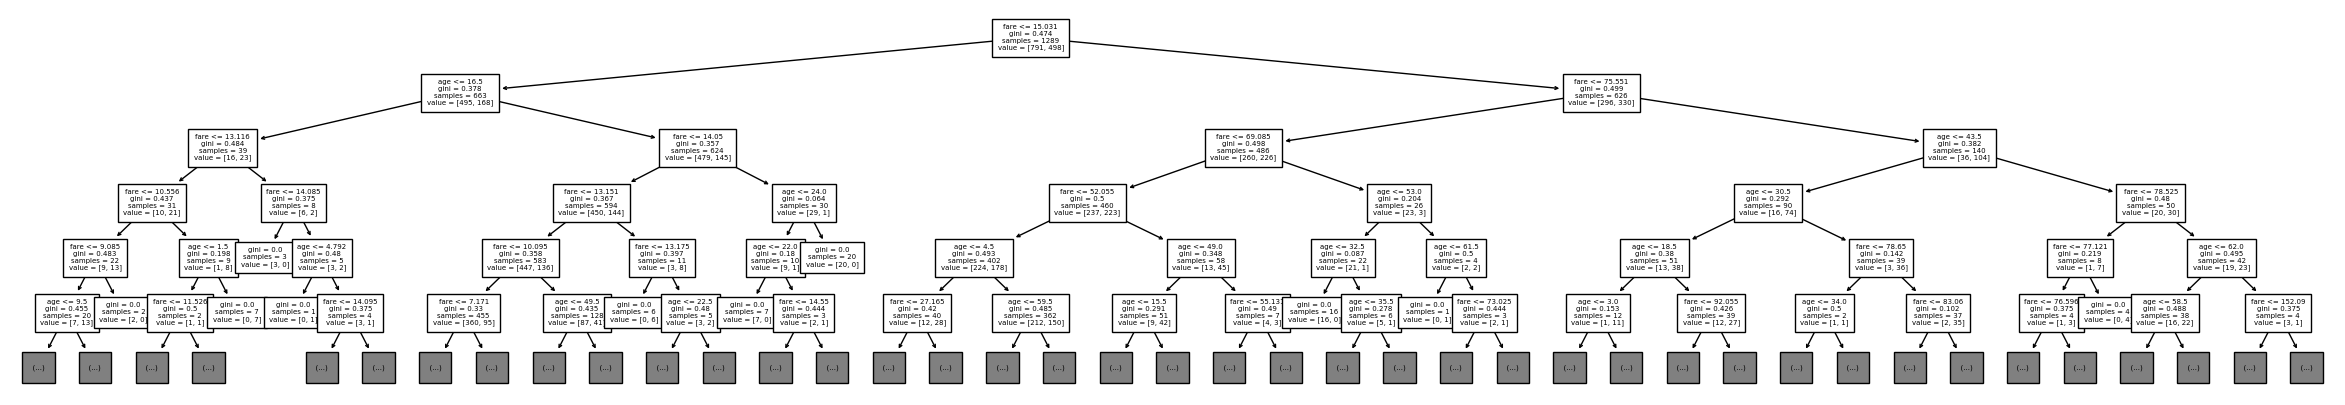

In [11]:
# Fit the pipeline to the data
pipeline.fit(dataset[X], dataset[y[0]])

# Create a figure and axis with a wider x-axis
fig, ax = plt.subplots(figsize=(30, 5))

# Plot the decision tree
sk.tree.plot_tree(pipeline.named_steps['decision tree classifier'],
               max_depth=5,
               feature_names=X,
               fontsize=5,
               ax=ax)

In [12]:
# Create a pipeline with preprocessor and KNeighborsClassifier
pipeline = Pipeline(steps=[
    ('knn classifier', KNeighborsClassifier(n_neighbors=default_n_neighbors))
])

cv_results_to_dict(pipeline, dataset)


Average Scores:
Precision: 0.6306 (+/- 0.0405)
Recall: 0.6276 (+/- 0.0420)
Accuracy: 0.6276 (+/- 0.0420)
F1 Score: 0.6260 (+/- 0.0395)

Fold 1
Precision: 0.5619
Recall: 0.5698
Accuracy: 0.5698
F1 Score: 0.5652

Fold 2
Precision: 0.6381
Recall: 0.6008
Accuracy: 0.6008
F1 Score: 0.6111

Fold 3
Precision: 0.6420
Recall: 0.6473
Accuracy: 0.6473
F1 Score: 0.6430

Fold 4
Precision: 0.6876
Recall: 0.6938
Accuracy: 0.6938
F1 Score: 0.6859

Fold 5
Precision: 0.6235
Recall: 0.6265
Accuracy: 0.6265
F1 Score: 0.6247


In [13]:
# Create a pipeline with preprocessor and GaussianNB classifier
pipeline = Pipeline(steps=[
    ('gaussian naive bayes classifier', GaussianNB())
])

cv_results_to_dict(pipeline, dataset)


Average Scores:
Precision: 0.6890 (+/- 0.0166)
Recall: 0.6625 (+/- 0.0219)
Accuracy: 0.6625 (+/- 0.0219)
F1 Score: 0.5951 (+/- 0.0224)

Fold 1
Precision: 0.7137
Recall: 0.6783
Accuracy: 0.6783
F1 Score: 0.6110

Fold 2
Precision: 0.7023
Recall: 0.6977
Accuracy: 0.6977
F1 Score: 0.6297

Fold 3
Precision: 0.6680
Recall: 0.6395
Accuracy: 0.6395
F1 Score: 0.5732

Fold 4
Precision: 0.6782
Recall: 0.6473
Accuracy: 0.6473
F1 Score: 0.5715

Fold 5
Precision: 0.6828
Recall: 0.6498
Accuracy: 0.6498
F1 Score: 0.5904


In [14]:
# Create a pipeline with preprocessor and GaussianNB classifier
pipeline = Pipeline(steps=[
    ('multinomial naive bayes classifier', MultinomialNB())
])

cv_results_to_dict(pipeline, dataset)


Average Scores:
Precision: 0.6616 (+/- 0.0251)
Recall: 0.6703 (+/- 0.0215)
Accuracy: 0.6703 (+/- 0.0215)
F1 Score: 0.6574 (+/- 0.0215)

Fold 1
Precision: 0.6228
Recall: 0.6357
Accuracy: 0.6357
F1 Score: 0.6254

Fold 2
Precision: 0.6670
Recall: 0.6822
Accuracy: 0.6822
F1 Score: 0.6703

Fold 3
Precision: 0.6828
Recall: 0.6860
Accuracy: 0.6860
F1 Score: 0.6737

Fold 4
Precision: 0.6444
Recall: 0.6550
Accuracy: 0.6550
F1 Score: 0.6383

Fold 5
Precision: 0.6912
Recall: 0.6926
Accuracy: 0.6926
F1 Score: 0.6794


In [15]:
# Create a pipeline with preprocessor and SVM classifier
pipeline = Pipeline(steps=[
    ('svm classifier', SVM())
])

cv_results_to_dict(pipeline, dataset)


Average Scores:
Precision: 0.6500 (+/- 0.0233)
Recall: 0.6548 (+/- 0.0216)
Accuracy: 0.6548 (+/- 0.0216)
F1 Score: 0.6164 (+/- 0.0229)

Fold 1
Precision: 0.6051
Recall: 0.6279
Accuracy: 0.6279
F1 Score: 0.6022

Fold 2
Precision: 0.6731
Recall: 0.6938
Accuracy: 0.6938
F1 Score: 0.6606

Fold 3
Precision: 0.6554
Recall: 0.6512
Accuracy: 0.6512
F1 Score: 0.6134

Fold 4
Precision: 0.6560
Recall: 0.6550
Accuracy: 0.6550
F1 Score: 0.6097

Fold 5
Precision: 0.6602
Recall: 0.6459
Accuracy: 0.6459
F1 Score: 0.5963


In [27]:
# Create a pipeline with preprocessor and MLP classifier
pipeline = Pipeline(steps=[
    ('mlp classifier', MLP())
])

cv_results_to_dict(pipeline, dataset)


Average Scores:
Precision: 0.6551 (+/- 0.0308)
Recall: 0.6548 (+/- 0.0330)
Accuracy: 0.6548 (+/- 0.0330)
F1 Score: 0.6474 (+/- 0.0314)

Fold 1
Precision: 0.6143
Recall: 0.6085
Accuracy: 0.6085
F1 Score: 0.6110

Fold 2
Precision: 0.6618
Recall: 0.6628
Accuracy: 0.6628
F1 Score: 0.6623

Fold 3
Precision: 0.6609
Recall: 0.6589
Accuracy: 0.6589
F1 Score: 0.6284

Fold 4
Precision: 0.6333
Recall: 0.6357
Accuracy: 0.6357
F1 Score: 0.6343

Fold 5
Precision: 0.7053
Recall: 0.7082
Accuracy: 0.7082
F1 Score: 0.7007


In [28]:
# Create a pipeline with preprocessor and RandomForestClassifier classifier
pipeline = Pipeline(steps=[
    ('rf classifier', RandomForestClassifier())
])

cv_results_to_dict(pipeline, dataset)


Average Scores:
Precision: 0.6777 (+/- 0.0249)
Recall: 0.6796 (+/- 0.0256)
Accuracy: 0.6796 (+/- 0.0256)
F1 Score: 0.6755 (+/- 0.0236)

Fold 1
Precision: 0.6379
Recall: 0.6473
Accuracy: 0.6473
F1 Score: 0.6404

Fold 2
Precision: 0.6615
Recall: 0.6512
Accuracy: 0.6512
F1 Score: 0.6554

Fold 3
Precision: 0.7034
Recall: 0.7054
Accuracy: 0.7054
F1 Score: 0.6954

Fold 4
Precision: 0.7007
Recall: 0.7054
Accuracy: 0.7054
F1 Score: 0.7009

Fold 5
Precision: 0.6850
Recall: 0.6887
Accuracy: 0.6887
F1 Score: 0.6853


## Custom Approach

In [18]:
# Define the parameter grid
param_grid = {
    'n_neighbors': range(1, 5)
}

# Create a scorer dictionary
scorers = {
    'precision': make_scorer(precision_score, average='weighted', zero_division=0),
    'recall': make_scorer(recall_score, average='weighted', zero_division=0),
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score, average='weighted', zero_division=0)
}

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=PMFRegressor(),
    param_grid=param_grid,
    cv=kf,  # Use the same KFold object as before
    scoring=scorers,
    refit='f1',  # Refit using the best F1 score
    return_train_score=False,
    n_jobs=-1  # Use all available cores
)

# Fit the GridSearchCV object
grid_search.fit(dataset[X], dataset[y[0]].map(class_map))

# Get the results
results = pd.DataFrame(grid_search.cv_results_)

# Process the results
avg_scores["custom"] = dict()
f1_by_k = {}

for i, row in results.iterrows():
    k = row['param_n_neighbors']
    avg_scores["custom"][k] = {
        "precision": row['mean_test_precision'],
        "recall": row['mean_test_recall'],
        "accuracy": row['mean_test_accuracy'],
        "f1": row['mean_test_f1'],
        "std_precision": row['std_test_precision'],
        "std_recall": row['std_test_recall'],
        "std_accuracy": row['std_test_accuracy'],
        "std_f1": row['std_test_f1']
    }
    f1_by_k[k] = row['mean_test_f1']

# Convert f1_by_k to DataFrame
f1_by_k = pd.DataFrame(f1_by_k.items(), columns=["k", "f1"])

# Get the best parameters and scores
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best F1 score: {best_score}")

# You can now use the best model for predictions
best_model = grid_search.best_estimator_

X:
[[42.    7.11]
 [13.   20.05]
 [16.   20.05]
 [39.   20.05]
 [16.    7.13]]
y:
[0 0 0 1 1]
Best parameters: {'n_neighbors': 1}
Best F1 score: 0.7064418720607802


### Results

In [19]:
print(f1_by_k.head())

   k        f1
0  1  0.706442
1  2  0.640870
2  3  0.643808
3  4  0.647680


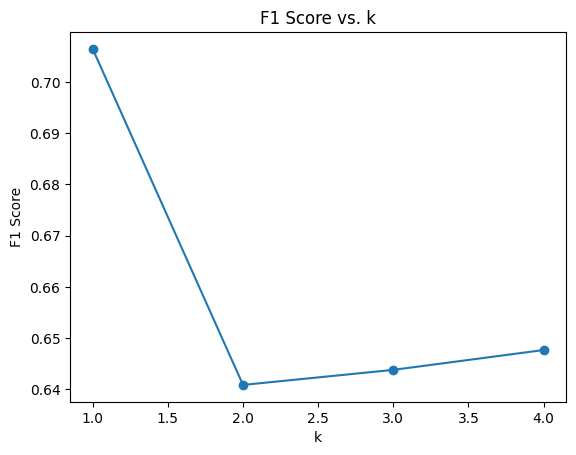

In [20]:
plt.plot(f1_by_k["k"], f1_by_k["f1"], marker='o') # Use plt.plot() for line plots
plt.title("F1 Score vs. k")
plt.xlabel("k")
plt.ylabel("F1 Score")
plt.show()

In [21]:
optimal_k = grid_search.best_params_['n_neighbors']

print(f"Optimal k: {optimal_k}")

Optimal k: 1


In [22]:
# Print average scores
print()
print("Average Scores for Optimal k:")
print(f"n_neighbors = {optimal_k}")
print(f"Precision: {avg_scores['custom'][optimal_k]['precision']:.4f} (+/- {avg_scores['custom'][optimal_k]['std_precision']:.4f})")
print(f"Recall: {avg_scores['custom'][optimal_k]['recall']:.4f} (+/- {avg_scores['custom'][optimal_k]['std_recall']:.4f})")
print(f"Accuracy: {avg_scores['custom'][optimal_k]['accuracy']:.4f} (+/- {avg_scores['custom'][optimal_k]['std_accuracy']:.4f})")
print(f"F1 Score: {avg_scores['custom'][optimal_k]['f1']:.4f} (+/- {avg_scores['custom'][optimal_k]['std_f1']:.4f})")


Average Scores for Optimal k:
n_neighbors = 1
Precision: 0.7097 (+/- 0.0052)
Recall: 0.7130 (+/- 0.0051)
Accuracy: 0.7130 (+/- 0.0051)
F1 Score: 0.7064 (+/- 0.0075)


In [23]:
model = best_model.fit(dataset[X], dataset[y[0]].map(class_map))
y_pred = pd.Series(model.predict(dataset[X]))

X:
[[42.    7.11]
 [13.   20.05]
 [16.   20.05]
 [39.   20.05]
 [16.    7.13]]
y:
[0 0 0 1 1]


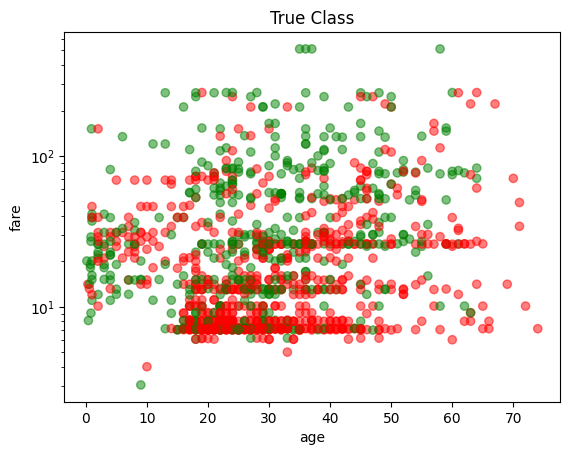

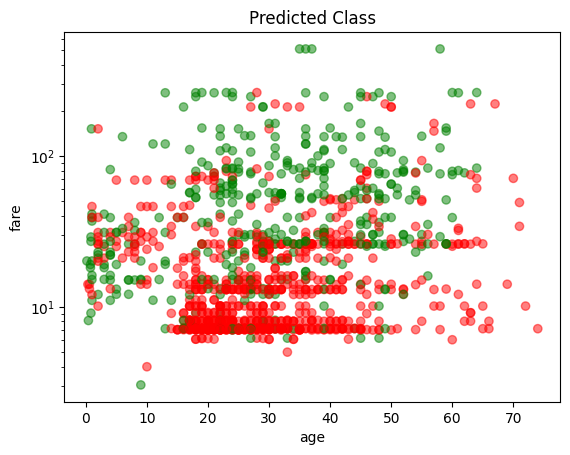

In [24]:
plt.scatter(dataset[X[0]],\
            dataset[X[1]],\
            c=dataset[y[0]].map(colormap),\
            alpha=0.5)

# Add labels and title
plt.title("True Class")
plt.xlabel(X[0])
plt.ylabel(X[1])
plt.yscale('log')
plt.show()

plt.scatter(dataset[X[0]],\
            dataset[X[1]],\
            c=y_pred.map(colormap),\
            alpha=0.5)

# Add labels and title
plt.title("Predicted Class")
plt.xlabel(X[0])
plt.ylabel(X[1])
plt.yscale('log')
plt.show()

## Compare Models

In [29]:
for model_name, scores in avg_scores.items():
      if model_name != "custom":
          print(f"{model_name}:")
          print(f"Precision: {scores['precision']:.4f} (+/- {scores['std_precision']:.4f})")
          print(f"Recall: {scores['recall']:.4f} (+/- {scores['std_recall']:.4f})")
          print(f"Accuracy: {scores['accuracy']:.4f} (+/- {scores['std_accuracy']:.4f})")
          print(f"F1 Score: {scores['f1']:.4f} (+/- {scores['std_f1']:.4f})")
          print()
      else:
          print(f"{model_name}:")
          print(f"Optimal n_neighbors = {optimal_k}")
          print(f"Precision: {avg_scores['custom'][optimal_k]['precision']:.4f} (+/- {avg_scores['custom'][optimal_k]['std_precision']:.4f})")
          print(f"Recall: {avg_scores['custom'][optimal_k]['recall']:.4f} (+/- {avg_scores['custom'][optimal_k]['std_recall']:.4f})")
          print(f"Accuracy: {avg_scores['custom'][optimal_k]['accuracy']:.4f} (+/- {avg_scores['custom'][optimal_k]['std_accuracy']:.4f})")
          print(f"F1 Score: {avg_scores['custom'][optimal_k]['f1']:.4f} (+/- {avg_scores['custom'][optimal_k]['std_f1']:.4f})")
          print()

decision tree classifier:
Precision: 0.6512 (+/- 0.0323)
Recall: 0.6525 (+/- 0.0302)
Accuracy: 0.6525 (+/- 0.0302)
F1 Score: 0.6494 (+/- 0.0313)

knn classifier:
Precision: 0.6306 (+/- 0.0405)
Recall: 0.6276 (+/- 0.0420)
Accuracy: 0.6276 (+/- 0.0420)
F1 Score: 0.6260 (+/- 0.0395)

gaussian naive bayes classifier:
Precision: 0.6890 (+/- 0.0166)
Recall: 0.6625 (+/- 0.0219)
Accuracy: 0.6625 (+/- 0.0219)
F1 Score: 0.5951 (+/- 0.0224)

multinomial naive bayes classifier:
Precision: 0.6616 (+/- 0.0251)
Recall: 0.6703 (+/- 0.0215)
Accuracy: 0.6703 (+/- 0.0215)
F1 Score: 0.6574 (+/- 0.0215)

svm classifier:
Precision: 0.6500 (+/- 0.0233)
Recall: 0.6548 (+/- 0.0216)
Accuracy: 0.6548 (+/- 0.0216)
F1 Score: 0.6164 (+/- 0.0229)

mlp classifier:
Precision: 0.6551 (+/- 0.0308)
Recall: 0.6548 (+/- 0.0330)
Accuracy: 0.6548 (+/- 0.0330)
F1 Score: 0.6474 (+/- 0.0314)

custom:
Optimal n_neighbors = 1
Precision: 0.7097 (+/- 0.0052)
Recall: 0.7130 (+/- 0.0051)
Accuracy: 0.7130 (+/- 0.0051)
F1 Score: 0.7064

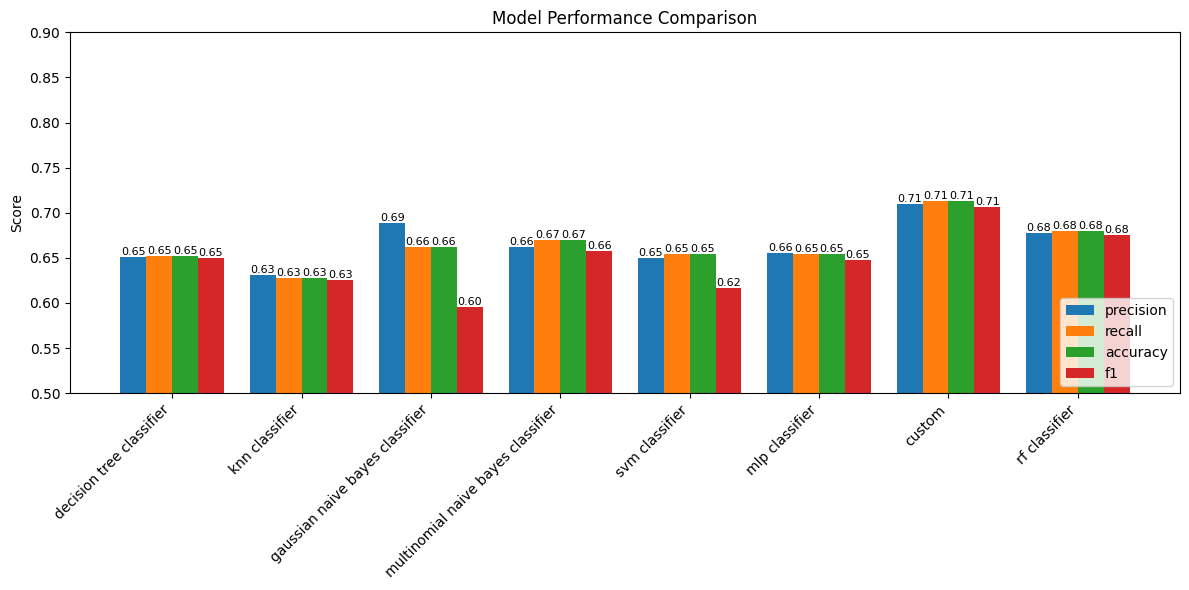

In [30]:
# Prepare data for plotting
models = list(avg_scores.keys())
metrics = ['precision', 'recall', 'accuracy', 'f1']
x = np.arange(len(models))
width = 0.2
fig, ax = plt.subplots(figsize=(12, 6))

# Plot bars for each metric
for i, metric in enumerate(metrics):
    values = []
    for model in models:
        if model == 'custom':
            values.append(avg_scores[model][optimal_k][metric])
        else:
            values.append(avg_scores[model][metric])
    ax.bar(x + i*width, values, width, label=metric)

# Customize the plot
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend(loc='lower right')
ax.set_ylim(0.5, 0.9)

# Add value labels on top of each bar
for i, metric in enumerate(metrics):
    values = []
    for model in models:
        if model == 'custom':
            values.append(avg_scores[model][optimal_k][metric])
        else:
            values.append(avg_scores[model][metric])
    for j, v in enumerate(values):
        ax.text(j + i*width, v, f'{v:.2f}', ha='center', va='bottom', rotation=0, fontsize=8)

plt.tight_layout()
plt.show()